# Setup

In [26]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

from source.Data import get_maang_data_default
maang = get_maang_data_default()

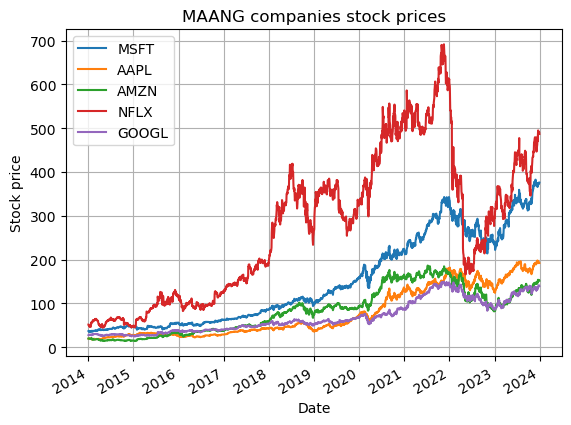

In [27]:
maang.plot(title='MAANG companies stock prices', ylabel='Stock price', xlabel='Date', grid=True);

In [28]:
maang.head()

,MSFT,AAPL,AMZN,NFLX,GOOGL
Date,,,,,
2014-01-02,37.160000,19.754642,19.898500,51.831429,27.855856
2014-01-03,36.910000,19.320715,19.822001,51.871429,27.652653
2014-01-06,36.130001,19.426071,19.681499,51.367142,27.960960
2014-01-07,36.410000,19.287144,19.901501,48.500000,28.500000
2014-01-08,35.759998,19.409286,20.096001,48.712856,28.559309


# Séries temporelles linéaires

In [29]:
### test de stationarité:

from statsmodels.tsa.stattools import adfuller
for stock in maang.columns:
    adf_test = adfuller(maang[stock])
    print(f'p-value: {adf_test[1]}')

## très grandes p valeurs donc pas stationnaires, netflix l'est deja plus que les autres

p-value: 0.9927234384380509
p-value: 0.9756974660253559
p-value: 0.7864132400309543
p-value: 0.6349859854696028
p-value: 0.9680574374697533


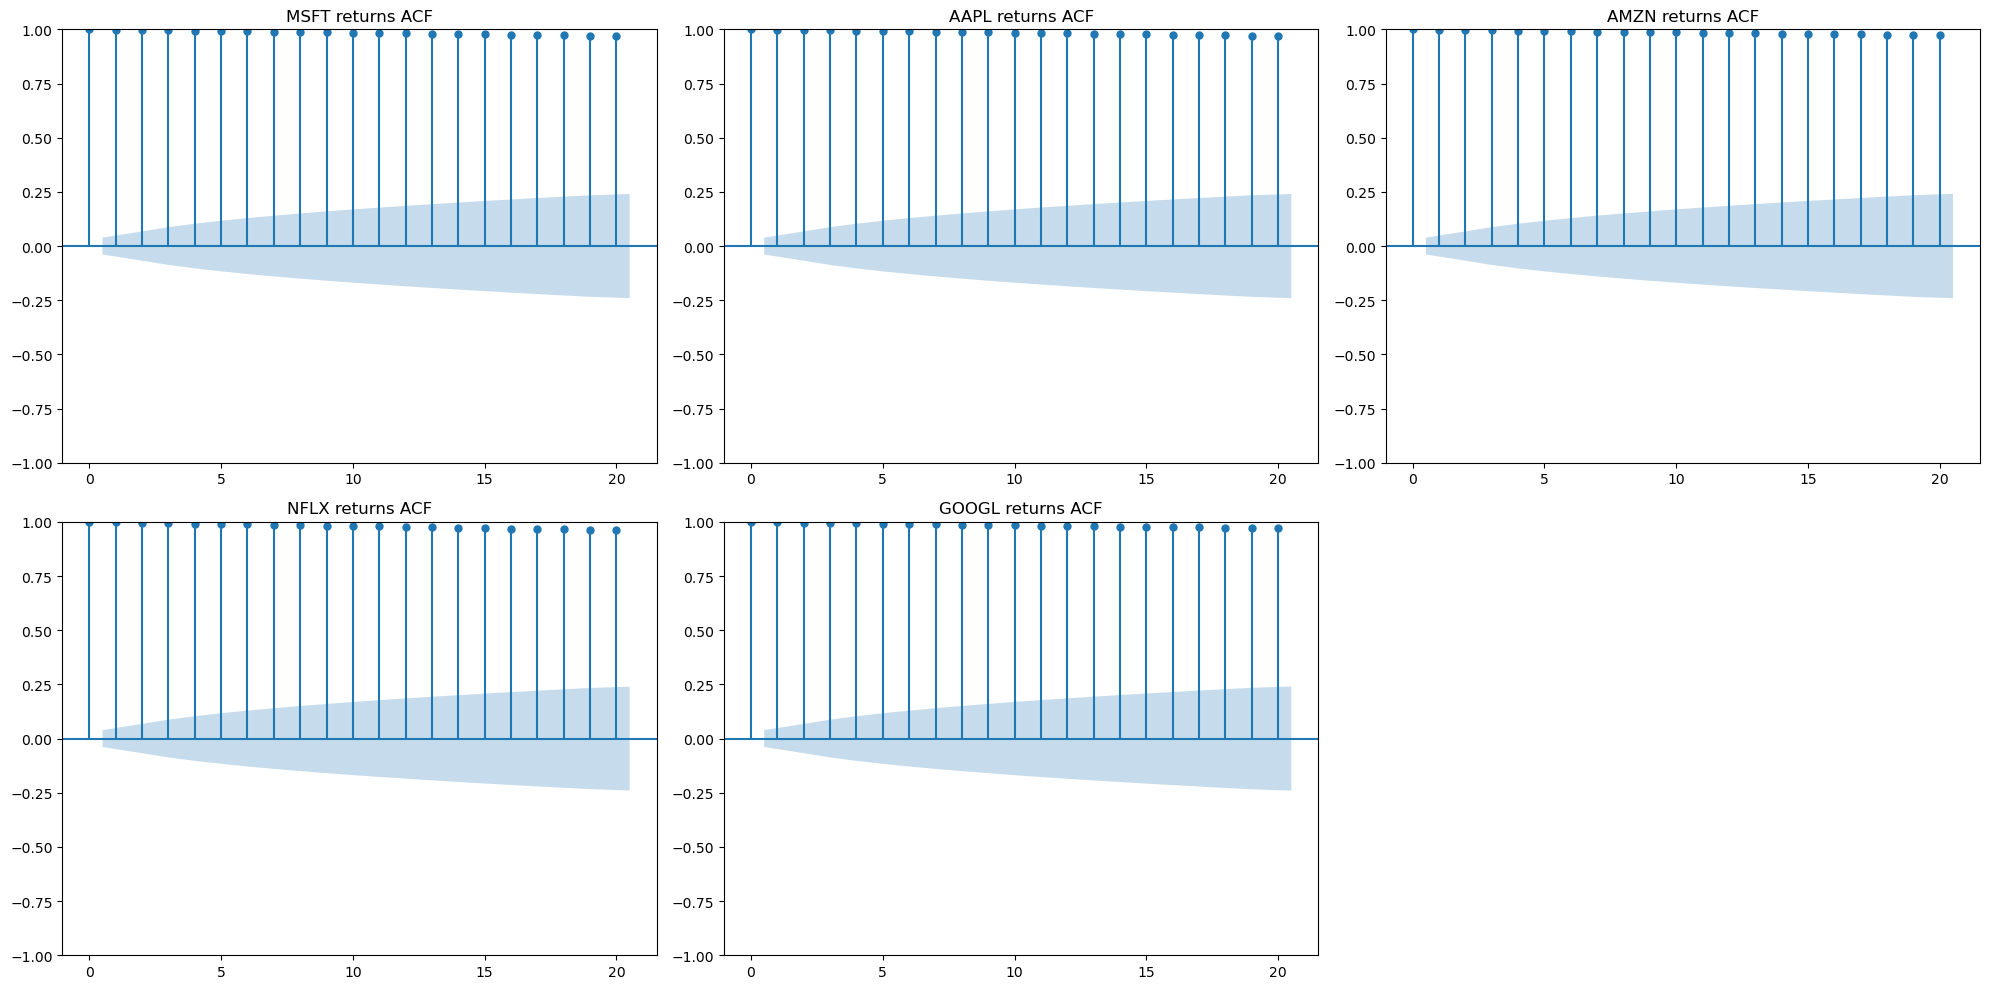

In [30]:
## confirmation par les ACC

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_acf(maang[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' returns ACF')
plt.tight_layout()
plt.show()

## très autocorrelé

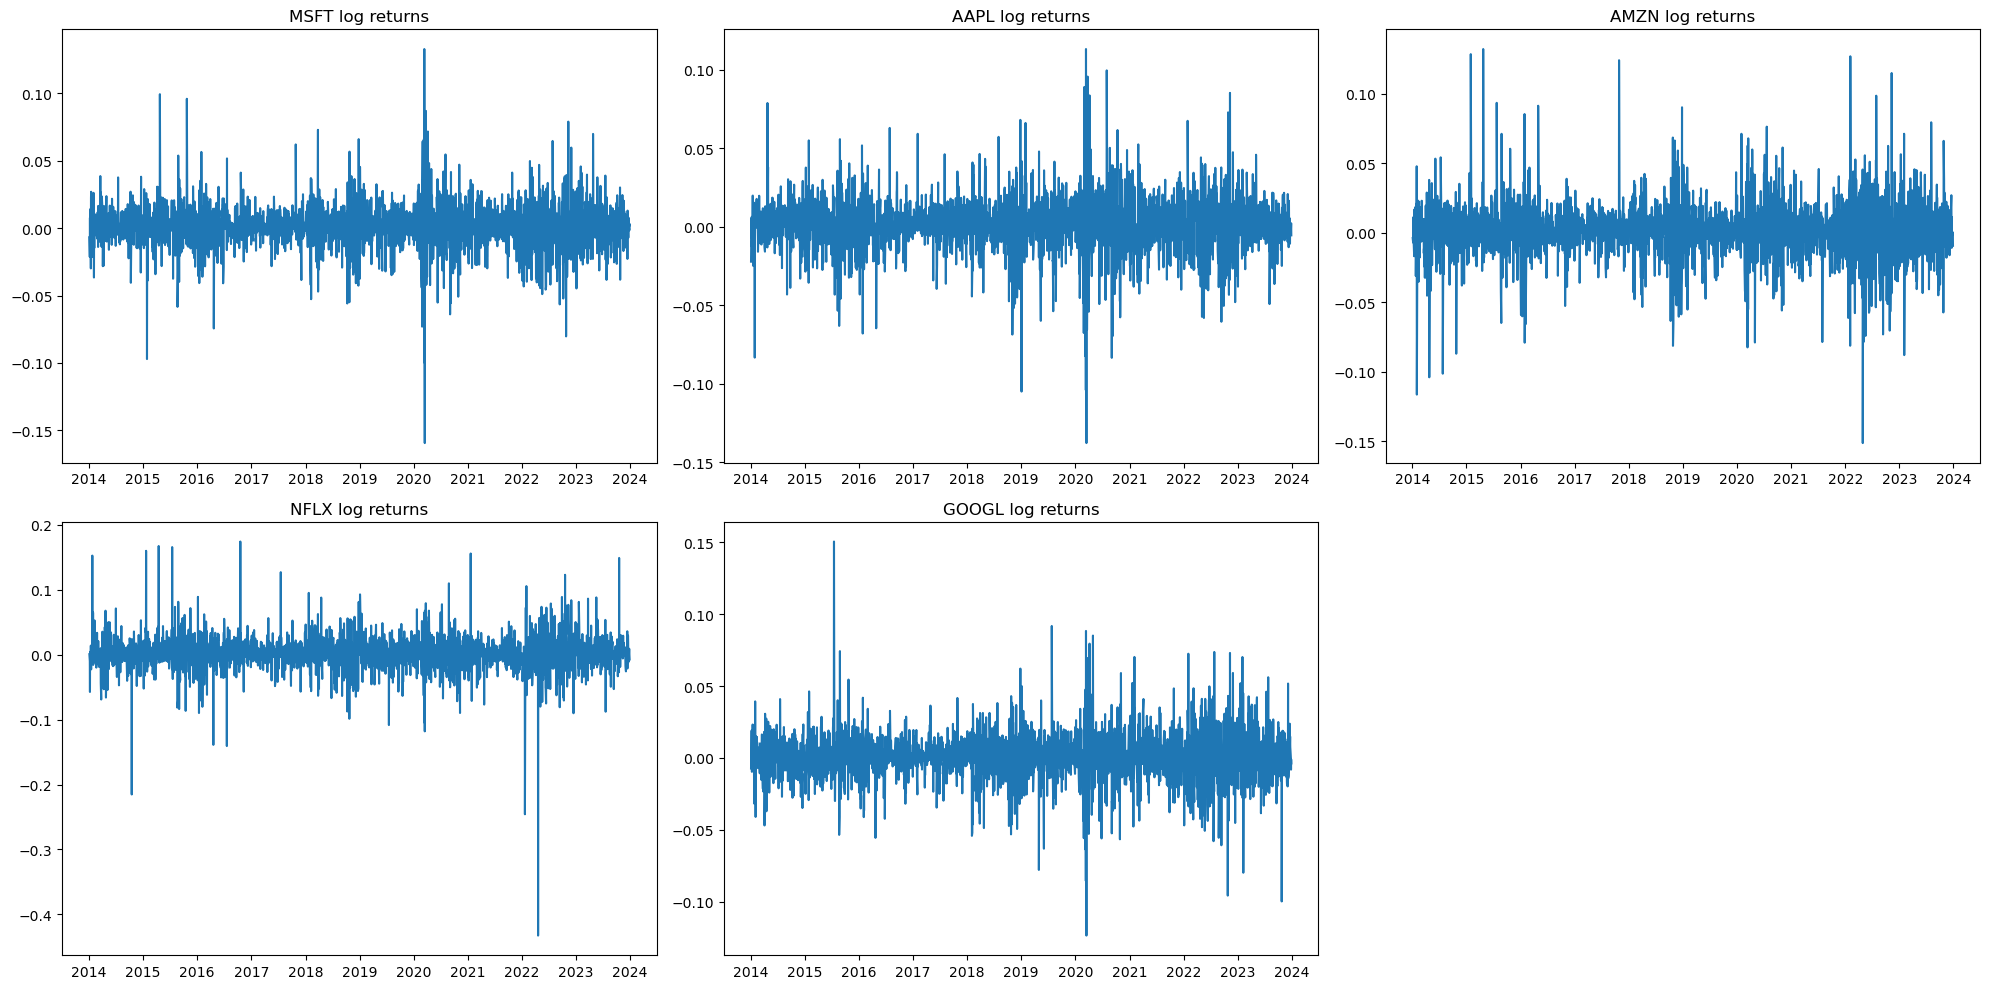

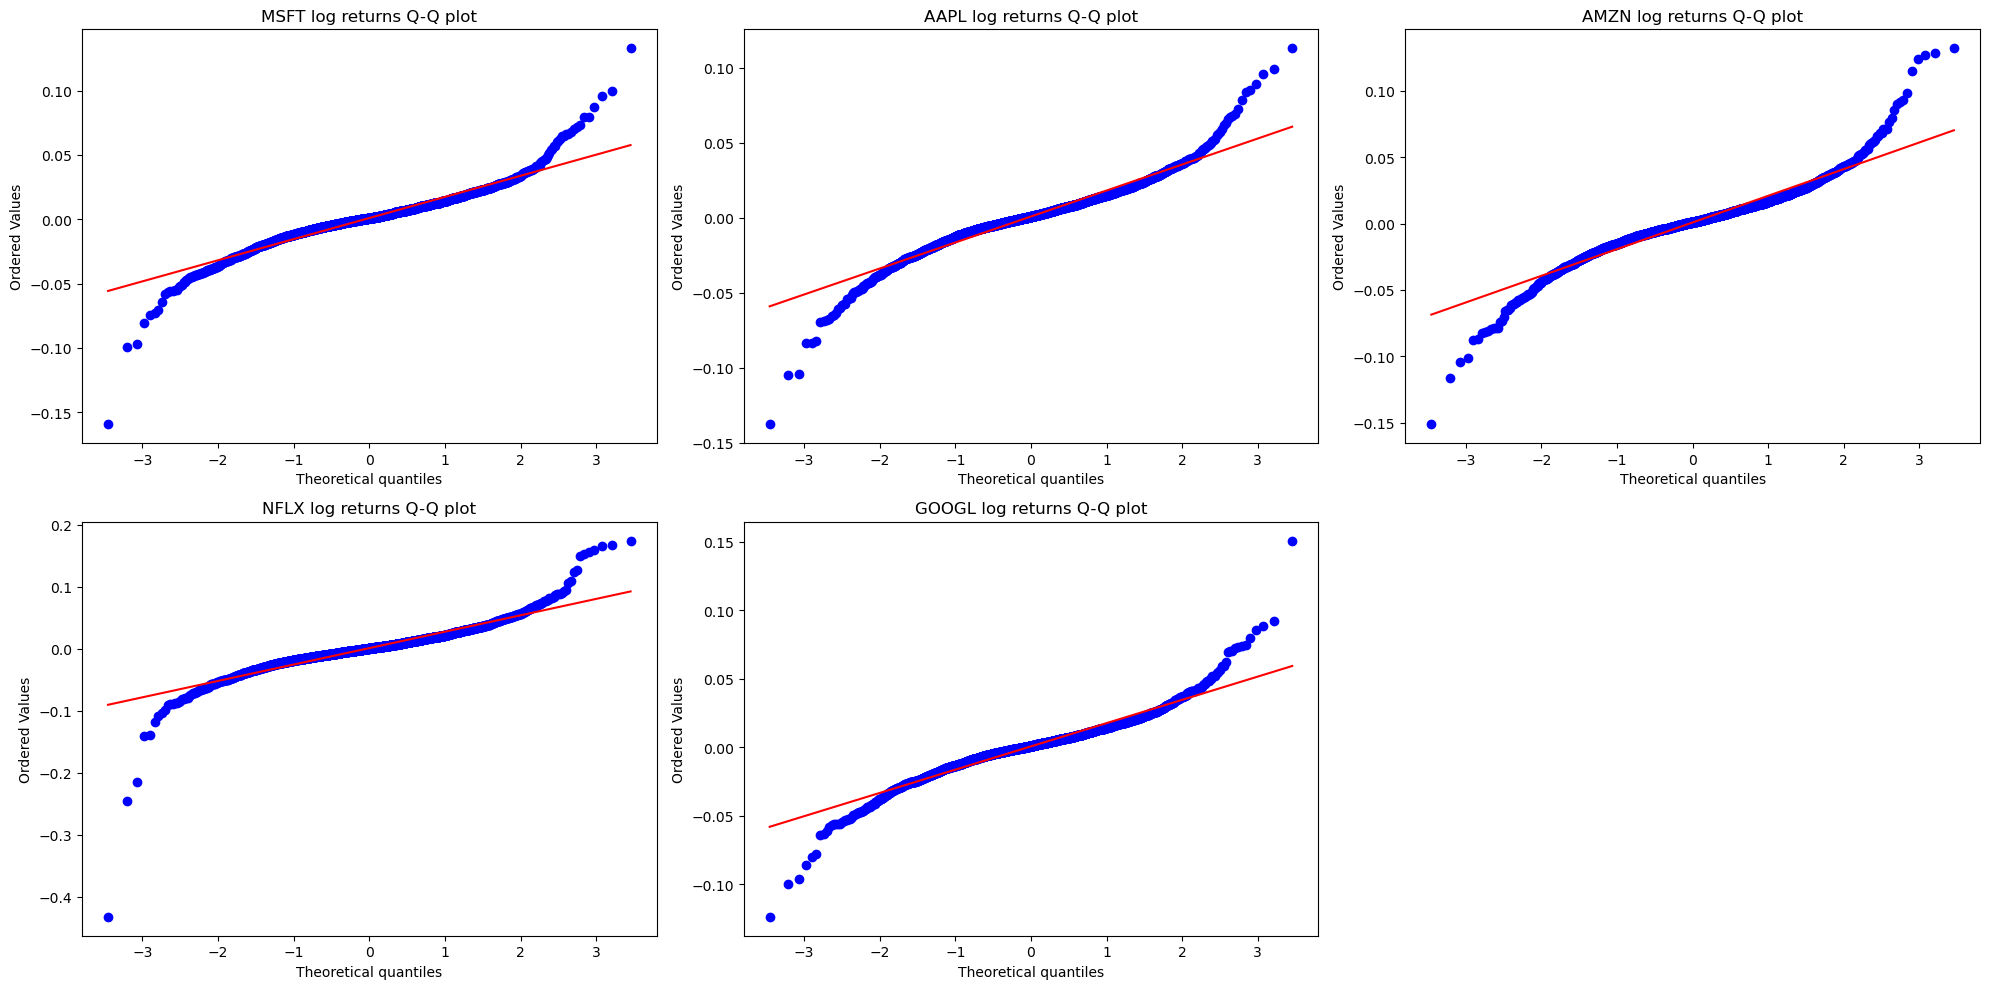

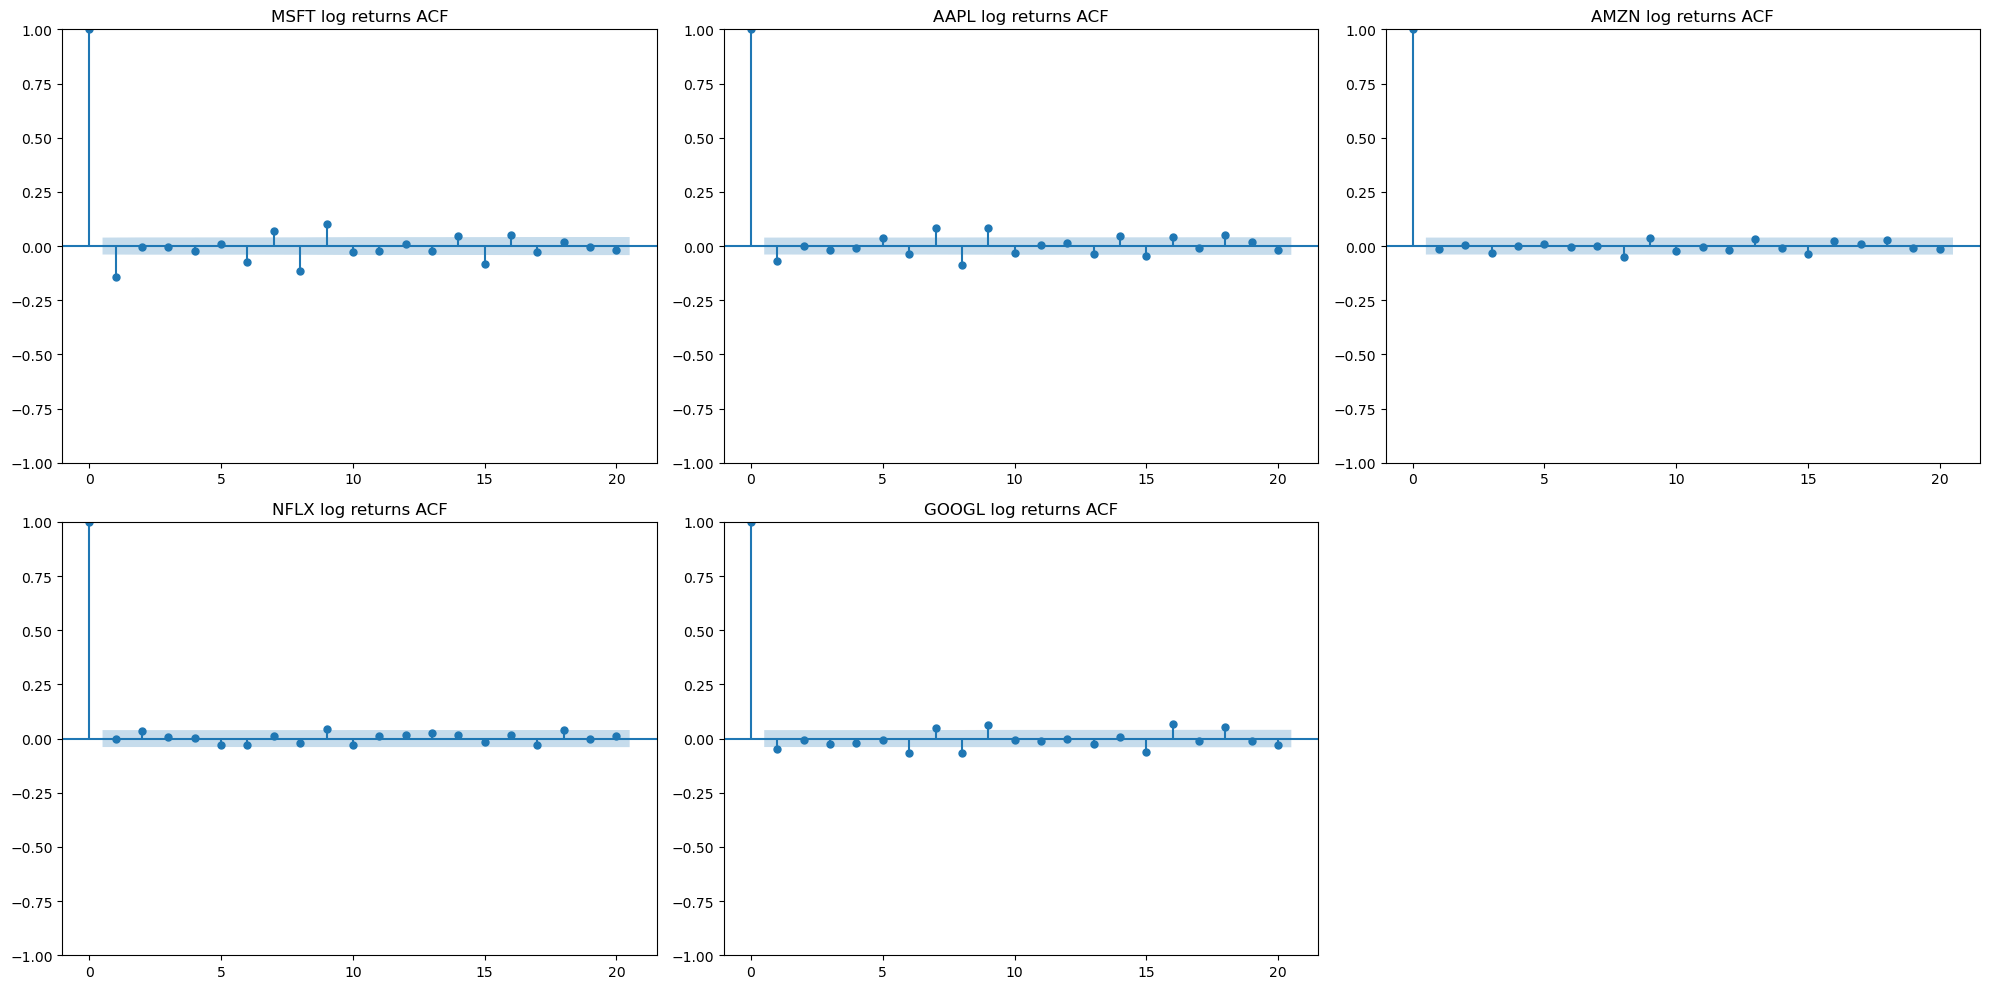

In [31]:
maang_log_returns = np.log(maang / maang.shift(1)).dropna()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(maang_log_returns[stock])
    plt.title(stock + ' log returns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sps.probplot(maang_log_returns[stock], plot=plt, dist='norm')
    plt.title(stock + ' log returns Q-Q plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_acf(maang_log_returns[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' log returns ACF')
plt.tight_layout()
plt.show()

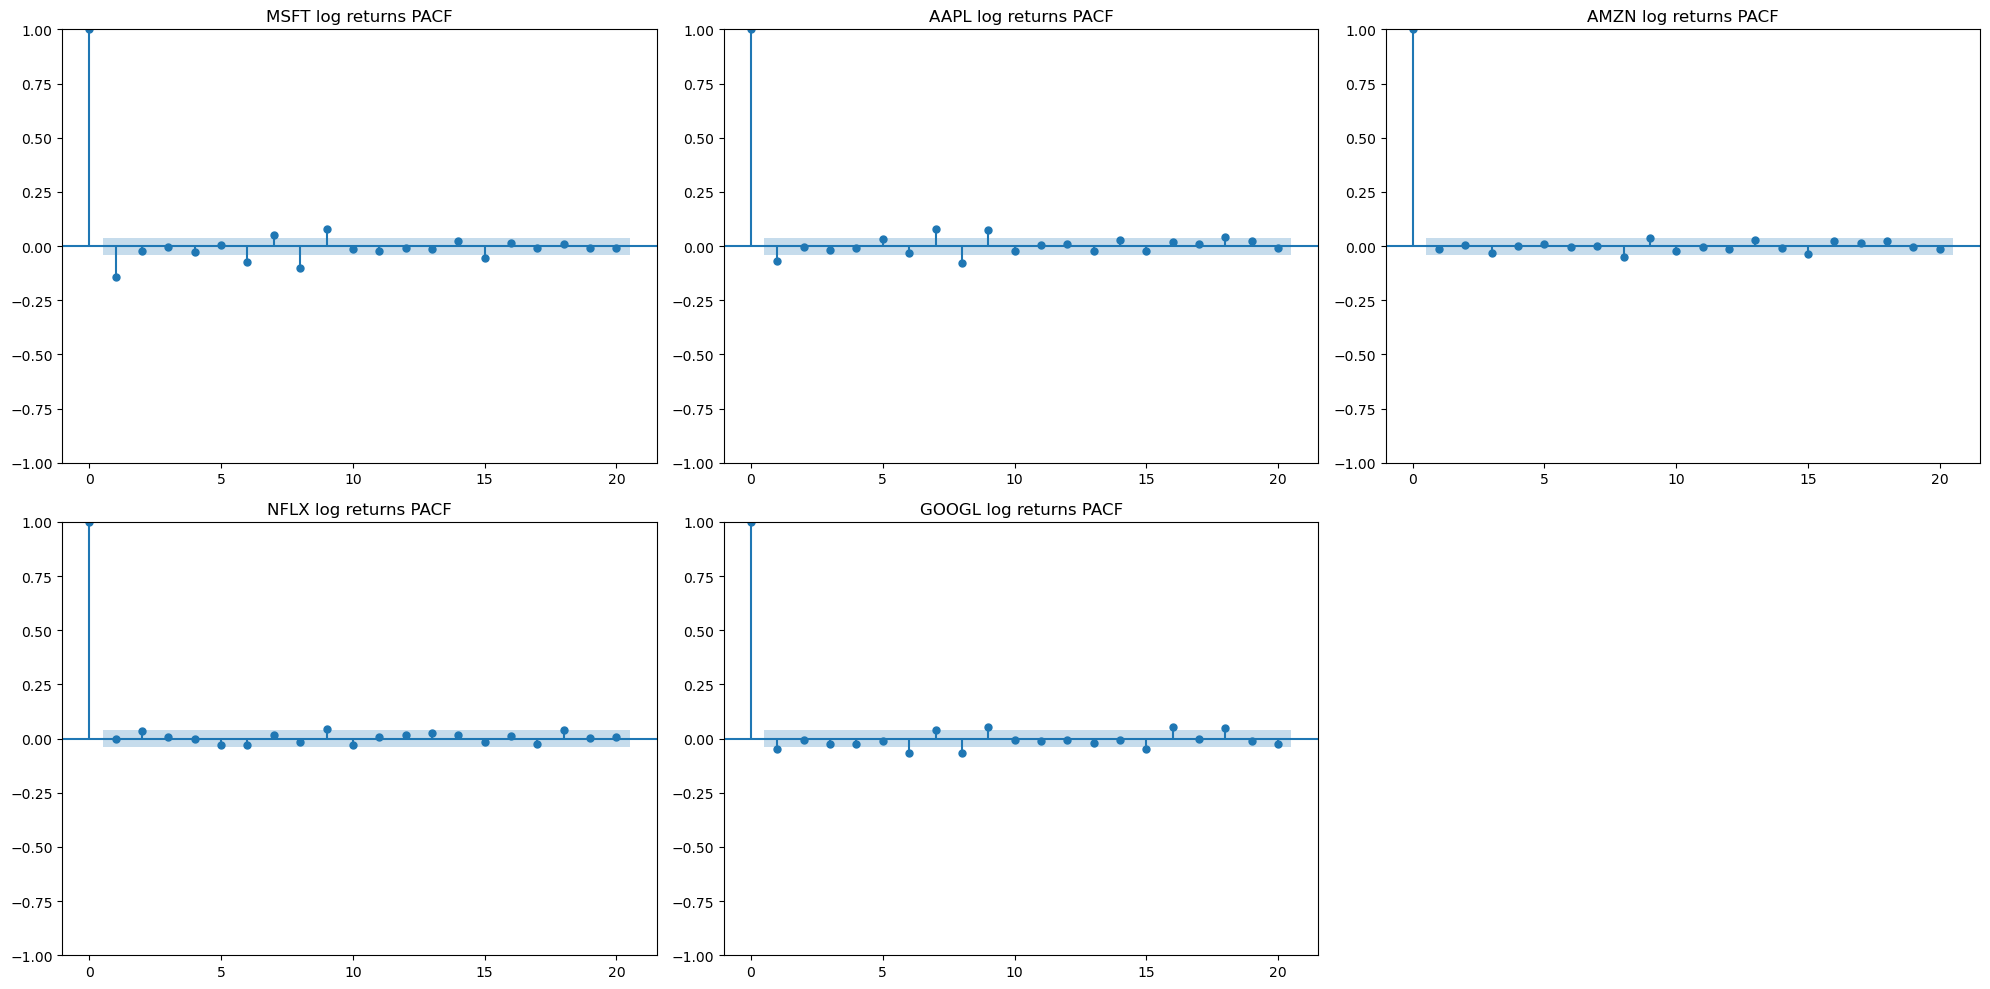

In [32]:
### partial auto correlation PCC 

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_pacf(maang_log_returns[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' log returns PACF')
plt.tight_layout()
plt.show()

In [33]:
for stock in maang_log_returns.columns:
    kurtosis = np.mean((maang_log_returns[stock] - maang_log_returns[stock].mean()) ** 4) / np.var(maang_log_returns[stock]) ** 2
    normalized_kurtosis = kurtosis - 3
    print(f'Kurtosis normalisé pour {stock}:\t {round(kurtosis, 3)}')

Kurtosis normalisé pour MSFT:	 11.111
Kurtosis normalisé pour AAPL:	 8.68
Kurtosis normalisé pour AMZN:	 9.124
Kurtosis normalisé pour NFLX:	 31.258
Kurtosis normalisé pour GOOGL:	 9.289


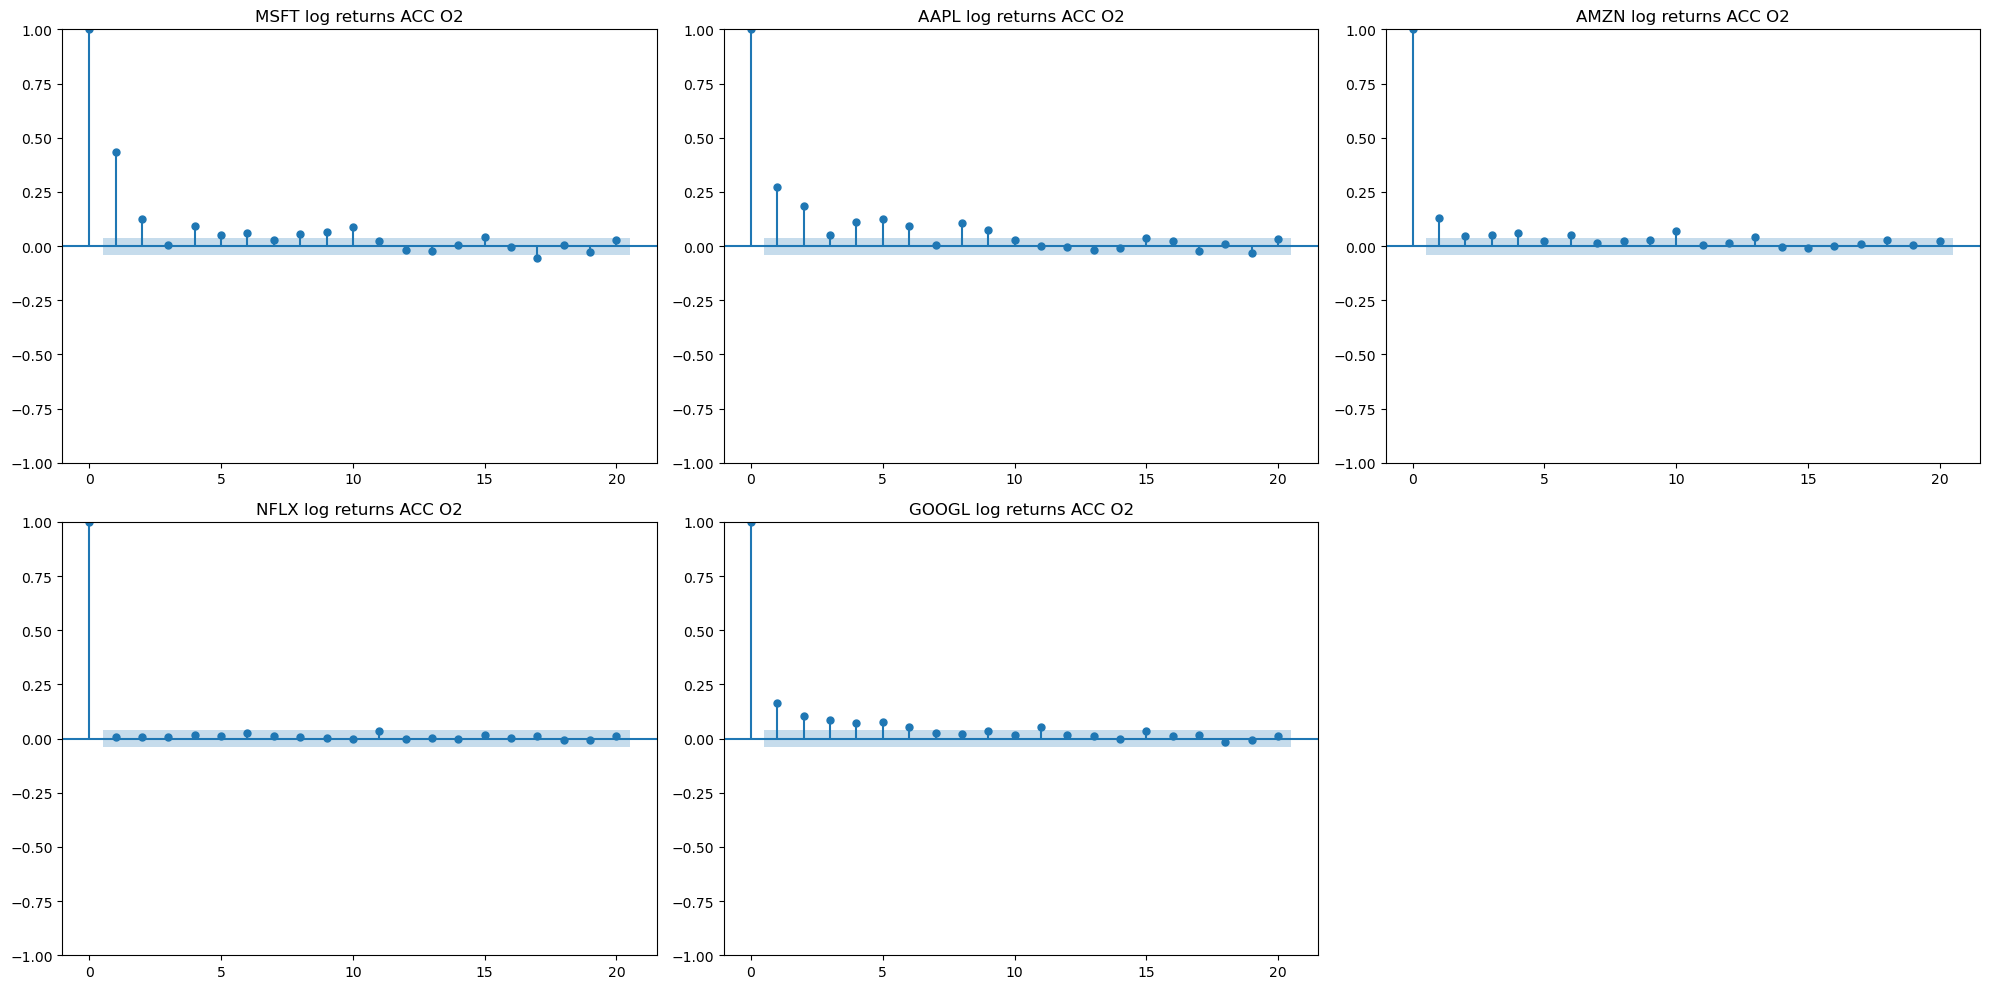

In [34]:
## ACC ordre 2 (normalement grosse ACC car cest pas du white noise non plus)


plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_pacf(maang_log_returns[stock]**2, lags=20, ax=plt.gca())
    plt.title(stock + ' log returns ACC O2')
plt.tight_layout()
plt.show()

In [35]:
### test de stationarité:

from statsmodels.tsa.stattools import adfuller
for stock in maang_log_returns.columns:
    adf_test = adfuller(maang_log_returns[stock])
    print(f'p-value: {adf_test[1]}')

## proche de 0, donc bcp plus stationnaire dejà, mieux qu'avant donc transofmztion passage au log efficace

p-value: 4.396093561531275e-30
p-value: 9.566654708036958e-29
p-value: 0.0
p-value: 0.0
p-value: 5.238910611569723e-21


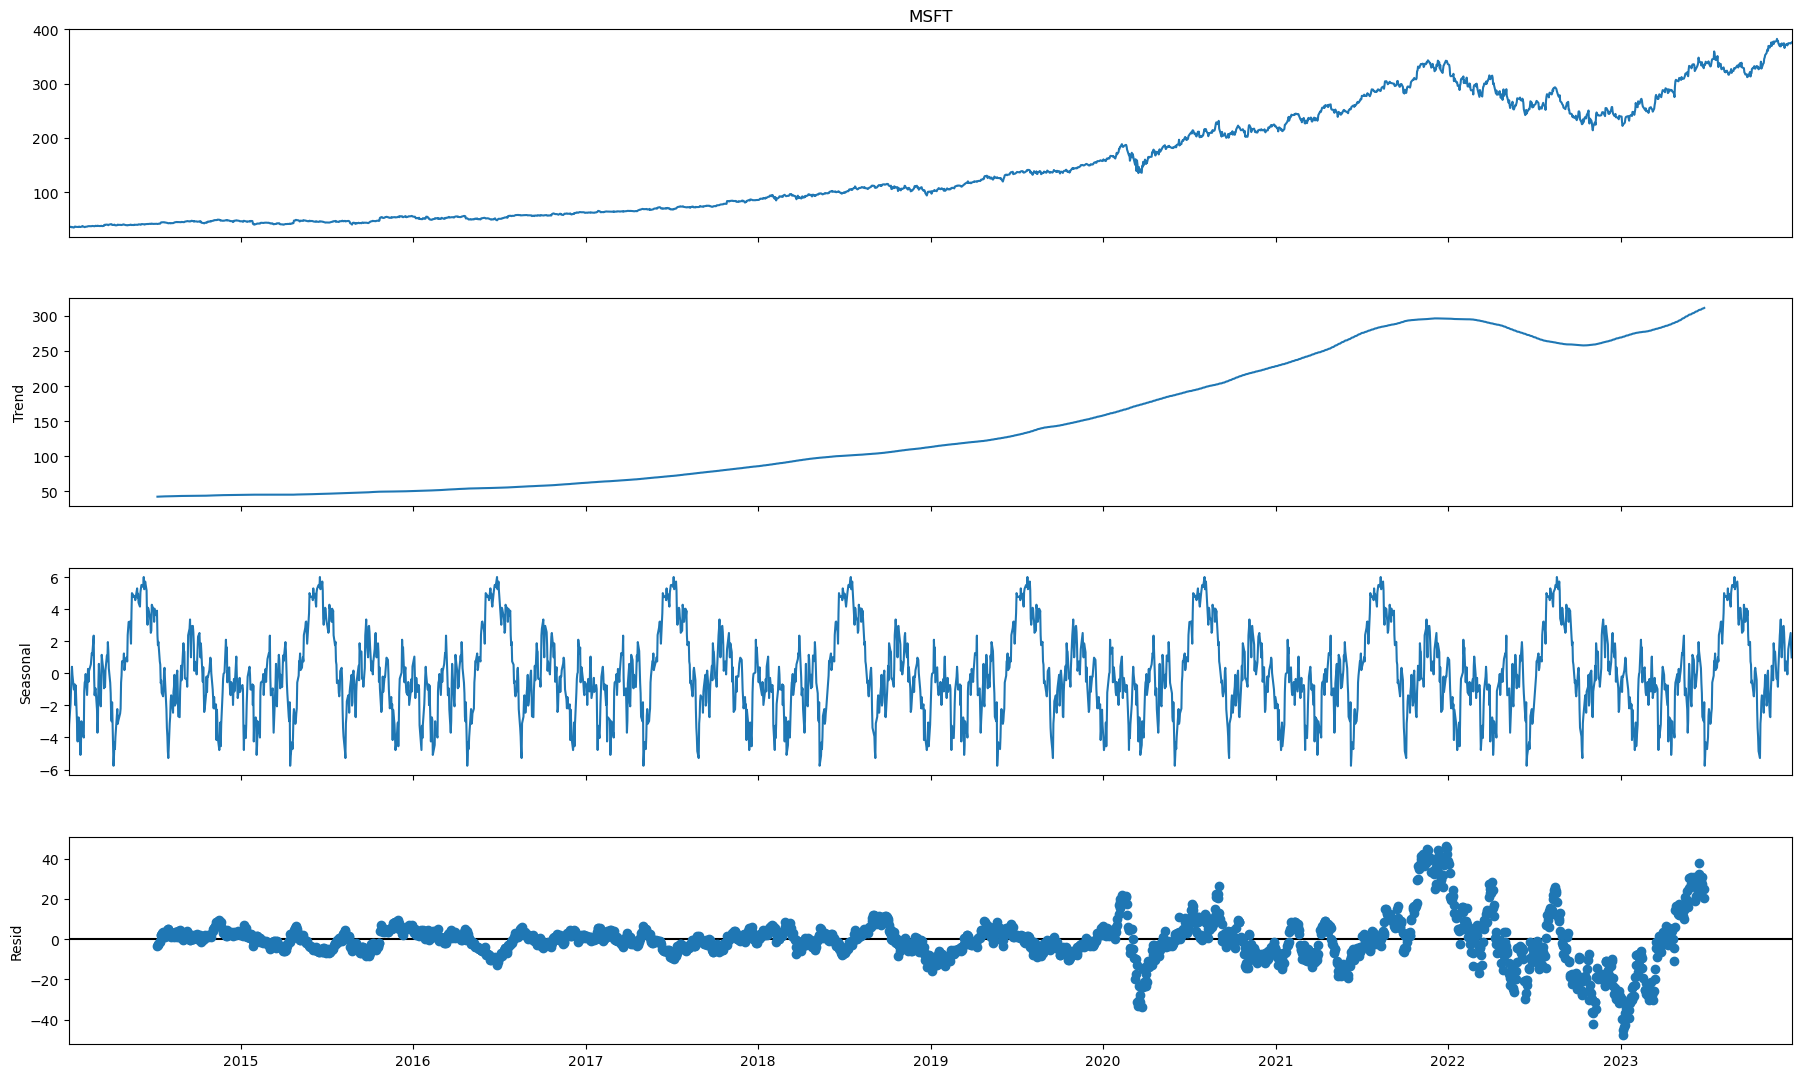

In [36]:
## Seasonality: belle formule dans le cours
decompose = sm.tsa.seasonal_decompose(maang['MSFT'], model='additive', period=258) # The frequncy is annual

figure = decompose.plot()
figure.set_figheight(12)
figure.set_figwidth(20)

# GARCH

In [37]:
# fit GARCH(1, 1) model to each stock
from arch import arch_model

maang_log_returns = 100 * maang_log_returns

garch_models = {}
for stock in maang_log_returns.columns:
    garch_models[stock] = arch_model(maang_log_returns[stock], vol='Garch', p=1, q=1).fit(disp='off')

for stock in maang_log_returns.columns:
    print(garch_models[stock].summary())

# simulate GARCH(1, 1) model
n = 1000
garch_simulations = {}
for stock in maang_log_returns.columns:
    garch_simulations[stock] = garch_models[stock].simulate(n)
    
plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(garch_simulations[stock])
    plt.title(stock + ' GARCH(1, 1) simulations')
plt.tight_layout()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4633.01
Distribution:                  Normal   AIC:                           9274.02
Method:            Maximum Likelihood   BIC:                           9297.34
                                        No. Observations:                 2515
Date:                Sat, Apr 06 2024   Df Residuals:                     2514
Time:                        17:26:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1174  2.721e-02      4.313  1.611e-05 [6.403e-0

AttributeError: 'ARCHModelResult' object has no attribute 'simulate'